Gravity turn gives us the following ODE:

$\begin{align}
\frac{dv}{dt} &= g(n-sin(\gamma)) \\
\frac{d\gamma}{dt} &= -\frac{1}{v}g\cdot cos(\gamma)
\end{align}$

With $n=\frac{a}{g}$


## Numerical solving

Problem with solving this is that if we start with a vertical rocket at $\gamma=90^{\circ}, v=0 \ m/s$, the set of equations obviously simplify to:

$\begin{align}
\frac{dv}{dt} &= gn \\
\frac{d\gamma}{dt} &= -\infty
\end{align}$

Which of course makes no sense. In practicality what this all means is just that if we don't give the rocket an initial kick, it won't start to fall. 
We could always start with slightly perturbed initial conditions and solve numerically, but as it turns out, the ODE is very stiff and this wont do 
a very good job. What will work instead is starting from a known final angle and velocity, and build our way back to $\gamma=90^{\circ}, v=0 \ m/s$.
This is rather simple and only requires reversing the sign of the ODEs:

$\begin{align}
\frac{dv}{dt} &= -g(n-sin(\gamma)) \\
\frac{d\gamma}{dt} &= \frac{1}{v}g\cdot cos(\gamma)
\end{align}$


In [6]:
from scipy.integrate import odeint, trapz, cumtrapz
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [7]:
from astropy.constants import g0 #gravitational constant

In [8]:
def simple_gravityturn(y, t, g, n):
    v, gamma = y
    dvdt = -g*(n-np.sin(gamma))
    dgammadt = g*np.cos(gamma)/v
    dydt = [dvdt, dgammadt]
    return dydt

In [9]:
def simple_gravityturn_forwards(y, t, g, n):
    v, gamma = y
    dvdt = g*(n-np.sin(gamma))
    dgammadt = -g*np.cos(gamma)/v
    dydt = [dvdt, dgammadt]
    return dydt

## Constant acceleration

Assuming g=9.81, n=3, $\gamma_{final}=20^{\circ}, v_{final}=1,500m/s$

In [10]:
g = 9.81
n = 3
gfinal = np.deg2rad(20)
vfinal = 1500

We will use one pyhtons ODE solvers: odeint

In [11]:
turnsolver = lambda t : odeint(simple_gravityturn, [vfinal, gfinal], [0,t], args=(g,n))[1,:]

If be backwards solve the original ODEs over 10 seconds we get:

In [12]:
turnsolver(10)

array([  1.24221367e+03,   4.15652097e-01])

As expected, the velocity is going down, and so it the angle. But when do we reach zero? Let's use fsolve:

In [13]:
velocity_only = lambda t: turnsolver(t)[0]
tzero = fsolve(velocity_only, 60)

In [14]:
tzero

array([ 63.8765345])

We can now get the full trajectory:

In [15]:
t = np.linspace(0, tzero, 1000)
yout = odeint(simple_gravityturn, [vfinal, gfinal], t, args=(g,n))
v,gamma = yout.transpose()

<IPython.core.display.Javascript object>


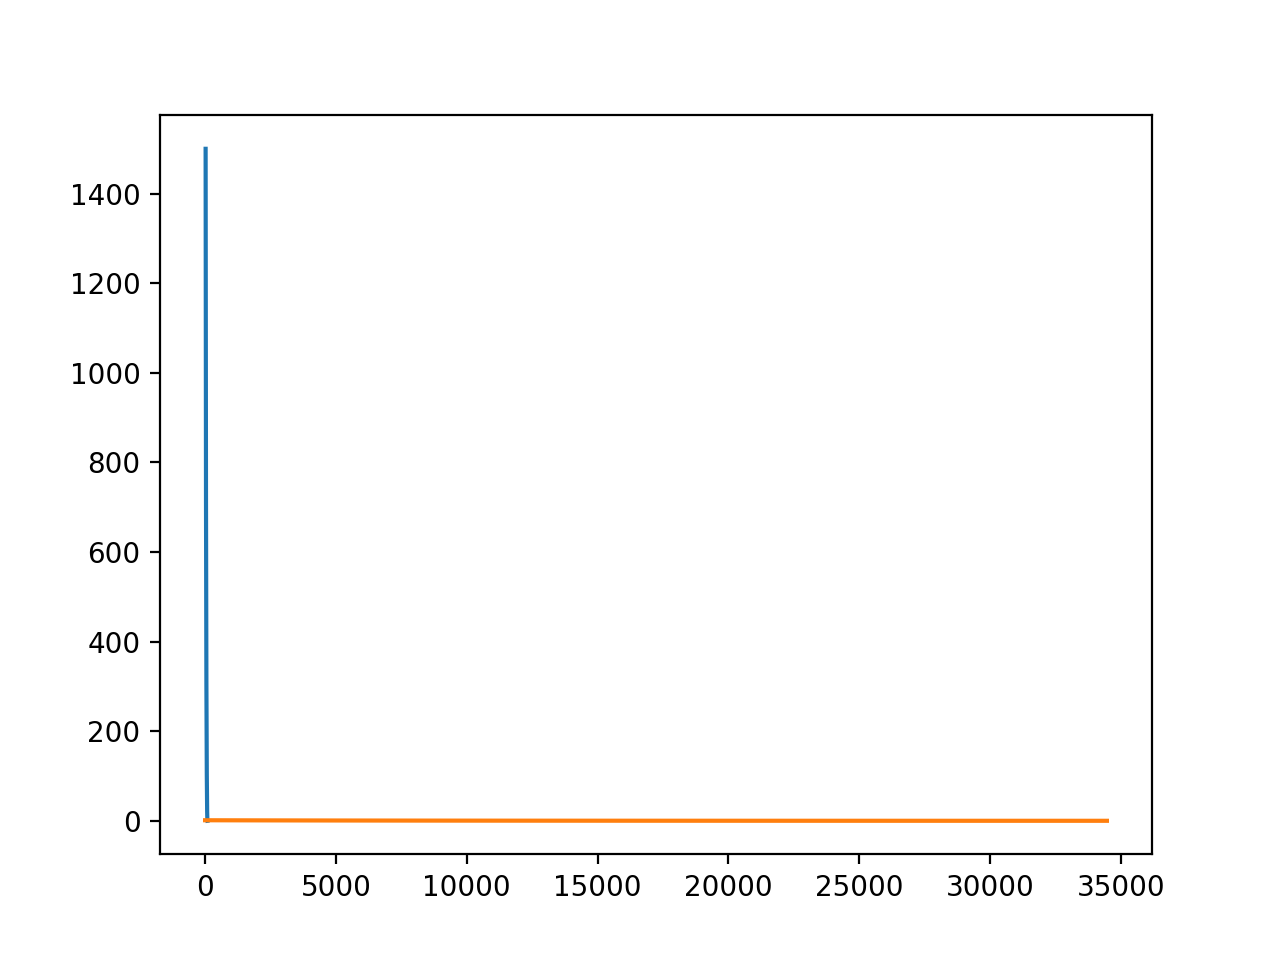

In [16]:
plt.plot(np.rad2deg(gamma), v);

### Gravity losses

Defined as $\int_{0}^{t_f} g\cdot sin(\gamma)$

In [17]:
trapz(g*np.sin(gamma), t)

379.88645079909463

## Delta II

In [134]:
Fsolid = 446e3
Fliq = 890e3
Isp_solid = 245.4
Isp_liq = 273
msolid = 13232 #kg
mfuelsolidbooster = 11765
mfuelliq = 96033
msolid_struct = msolid-mfuelsolidbooster
mtotal = 231870 #kg

csolid = Isp_solid*g
cliq = Isp_liq*g
mdot_solid = mfuelsolidbooster/63.3
mdot_liq = mfuelliq/260.5


mfinal_guess = mtotal - 9*mfuelsolidbooster

In [167]:
F = lambda t: np.piecewise(t, 
                           [(t >= 0) & (t <= 63.3), 
                            (t > 63.3) & (t <= 65.8), 
                            (t > 65.8)], [6*Fsolid+Fliq, Fliq, 3*Fsolid+Fliq])
m_solidfuel = lambda t: np.interp(t, np.array([0, 63.3, 65.8, 129]),
                        np.array([0, 
                        6*mfuelsolidbooster, 
                        6*mfuelsolidbooster,
                        9*mfuelsolidbooster]))
m_solid_struct = lambda t: np.piecewise(t, 
                           [(t >= 66) & (t <= 67), 
                            (t > 67) & (t <= 132), 
                            (t > 132)], [3*msolid_struct, 6*msolid_struct, 9*msolid_struct])
m_liqpart = lambda t: np.interp(t, np.array([0, 260.5]), np.array([0, mfuelliq]))
m = lambda t: mtotal-m_solidfuel(t)-m_solid_struct(t)-m_liqpart(t)

<IPython.core.display.Javascript object>


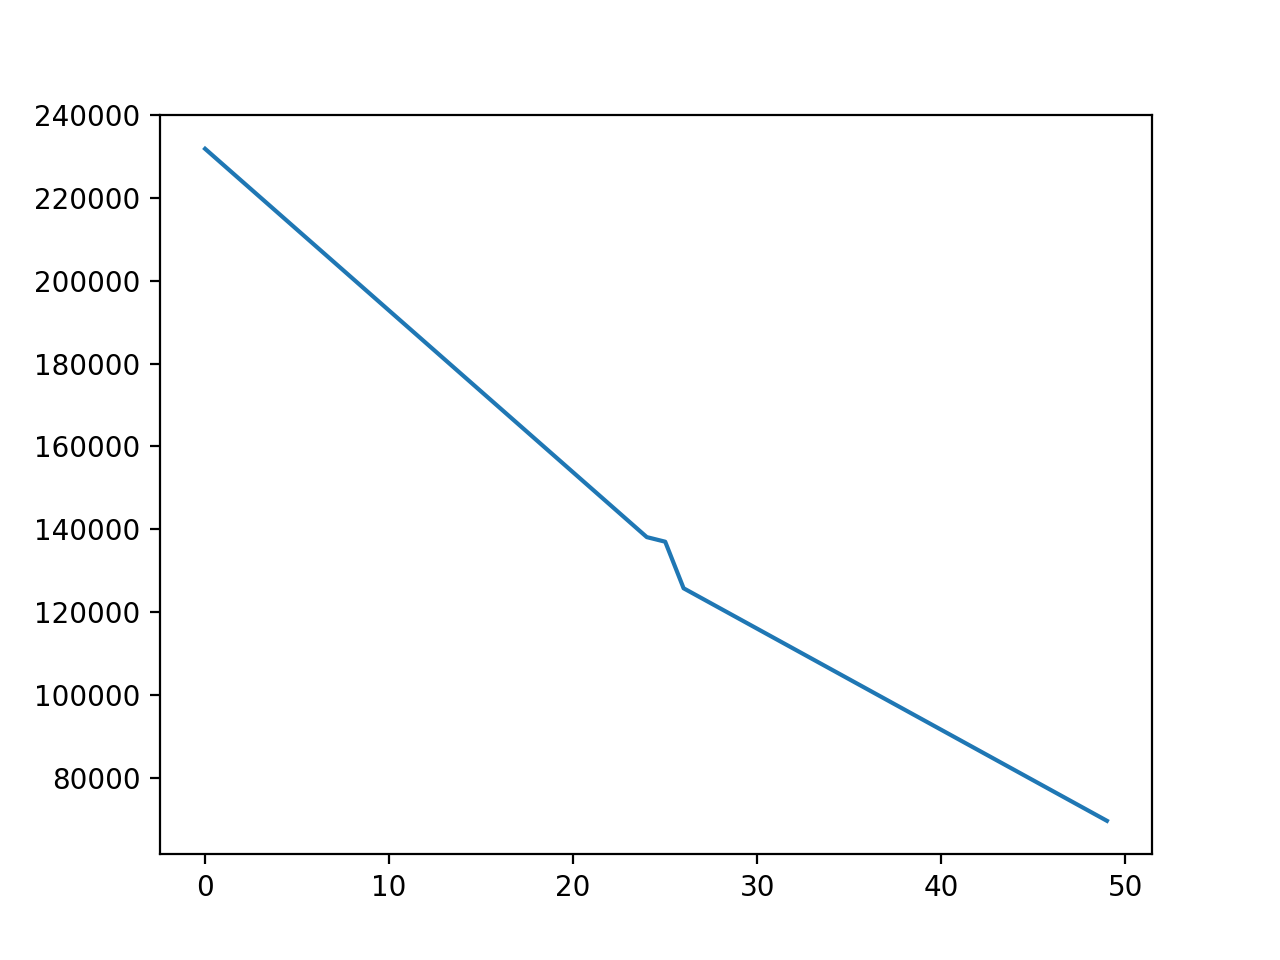

In [168]:
plt.figure()
plt.plot(m(np.linspace(0,129)))

In [169]:
def real_gravityturn(y, t, g, F, m, tf):
    v, gamma = y
    dvdt = -F(tf-t)/m(tf-t)+g*np.sin(gamma)
    dgammadt = g*np.cos(gamma)/v
    dydt = [dvdt, dgammadt]
    return dydt

In [170]:
realturnsolver = lambda t : odeint(real_gravityturn, [vfinal, gfinal], [0,t], args=(g,F,m,t))[1,:]

In [171]:
velocity_only = lambda t: realturnsolver(t)[0]
tzero = fsolve(velocity_only, 60)

In [172]:
tzero

array([ 115.07624814])

In [173]:
realturnsolver(tzero)

array([ -1.39710479e-06,   1.57079633e+00])

In [174]:
t = np.linspace(0, tzero, 1000)
yout = odeint(real_gravityturn, [vfinal, gfinal], t, args=(g,F,m,tzero))
v,gamma = yout.transpose()

In [175]:
trapz(g*np.sin(gamma), t)

822.08631999177169

## Drag

In [163]:
R = 287
T = 290
H = R*T/g
rho0 = 1.225
CD = 2
D = 2.896
A = np.pi*(D/2)**2

In [176]:
def drag_gravityturn(y, t, g, F, m, tf):
    v, gamma, z = y
    rho = rho0*np.exp(-z/H)
    dvdt = -F(tf-t)/m(tf-t)+g*np.sin(gamma)
    dgammadt = g*np.cos(gamma)/v
    dzdt = -v*np.sin(gamma)
    dydt = [dvdt, dgammadt, dzdt]
    return dydt

In [177]:
dragsolver = lambda t, z: odeint(drag_gravityturn, [vfinal, gfinal, z], [0,t], args=(g,F,m,t))[1,:]

In [178]:
zfinal = 30000
velocity_only = lambda x: dragsolver(x[0], x[1])[[0,2]]
tzero = fsolve(velocity_only, np.array([50, zfinal]))

In [179]:
tzero

array([   115.07624511,  40553.58894438])

In [182]:
t = np.linspace(0, tzero[0], 100)
yout = odeint(drag_gravityturn, [vfinal, gfinal, tzero[1]], t, args=(g,F,m,tzero[0]))
v,gamma,z = yout.transpose()

In [183]:
rho = rho0*np.exp(-z/H)

<IPython.core.display.Javascript object>


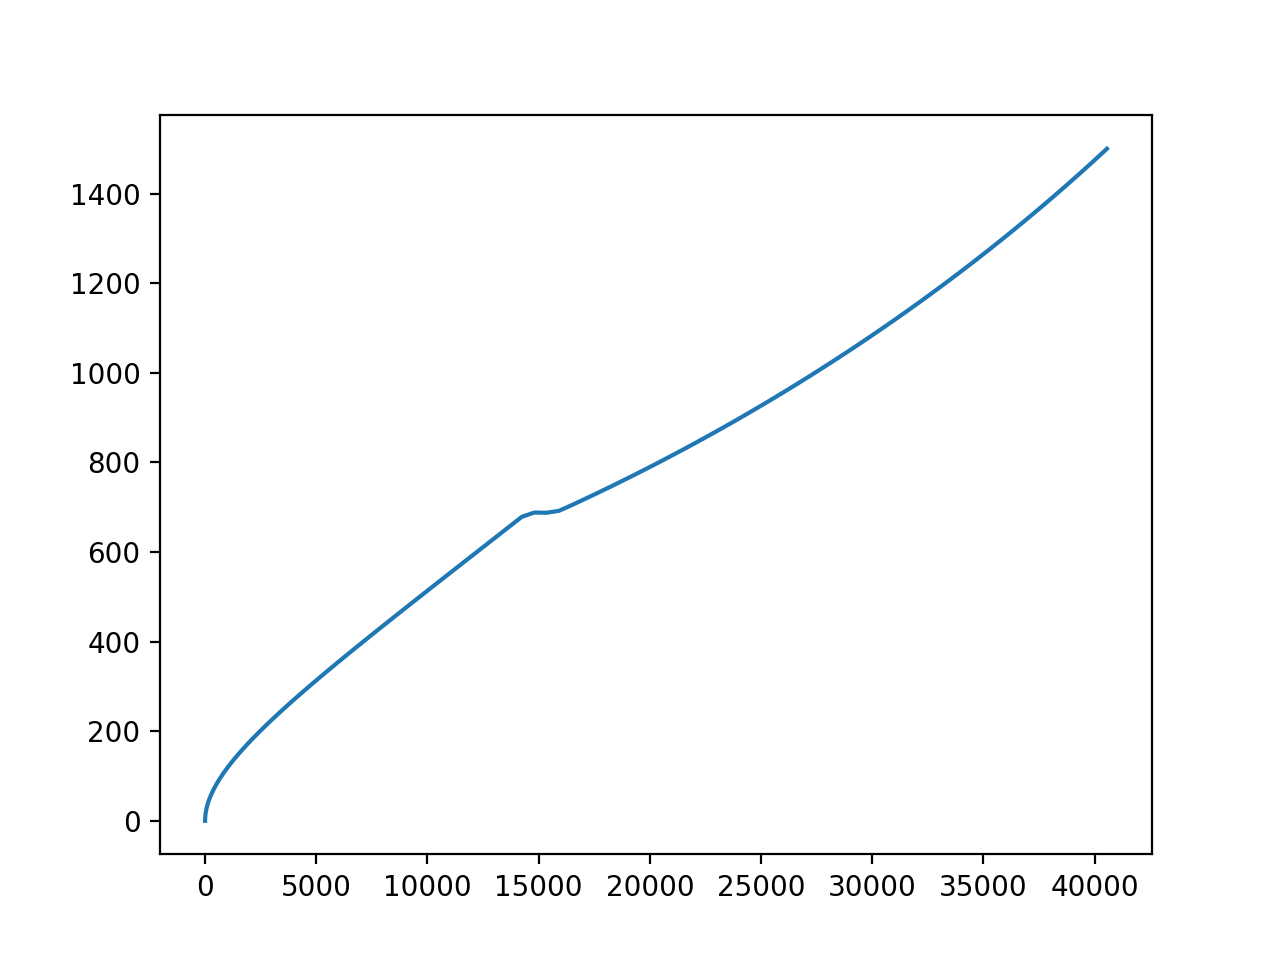

In [184]:
plt.figure()
plt.plot(z, v)

In [187]:
trapz(0.5*CD*A*rho*v**2/m(t), t)

263.85672542804912

In [186]:
trapz(g*np.sin(gamma), t)

822.07995747621226